### SET UP THE ENVIRONMENT

In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
import regex as re
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### LOAD AND PREPROCESS DATA

In [2]:
# Step 1: Load and preprocess the dataset
data = pd.read_excel('Online Retail.xlsx')

# Preprocess the data
data['Description'] = data['Description'].str.strip() # Strip whitespaces
data.dropna(axis=0, subset=['InvoiceNo'], inplace=True) # Drop rows where InvoiceNo is NaN
data['InvoiceNo'] = data['InvoiceNo'].astype('str') # Convert InvoiceNo to string
data = data[~data['InvoiceNo'].str.contains('C')] # Remove cancelled orders

# Ensure all descriptions are strings and handle NaN values
data['Description'] = data['Description'].astype(str).fillna('Missing')

# Group the data into transactions
transactions = data.groupby(['InvoiceNo', 'InvoiceDate'])['Description'].apply(list).reset_index()

print("Data shape:", data.shape)
print("\nSample transactions:")
print(transactions.head())

Data shape: (532621, 8)

Sample transactions:
  InvoiceNo         InvoiceDate  \
0    536365 2010-12-01 08:26:00   
1    536366 2010-12-01 08:28:00   
2    536367 2010-12-01 08:34:00   
3    536368 2010-12-01 08:34:00   
4    536369 2010-12-01 08:35:00   

                                         Description  
0  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...  
1  [HAND WARMER UNION JACK, HAND WARMER RED POLKA...  
2  [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...  
3  [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...  
4                         [BATH BUILDING BLOCK WORD]  


### EDA

In [3]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22106 non-null  object        
 1   InvoiceDate  22106 non-null  datetime64[ns]
 2   Description  22106 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 518.2+ KB


In [4]:
transactions.InvoiceDate.min()

Timestamp('2010-12-01 08:26:00')

In [5]:
transactions.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

/opt/anaconda3/envs/ai4cm-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/envs/ai4cm-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/envs/ai4cm-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


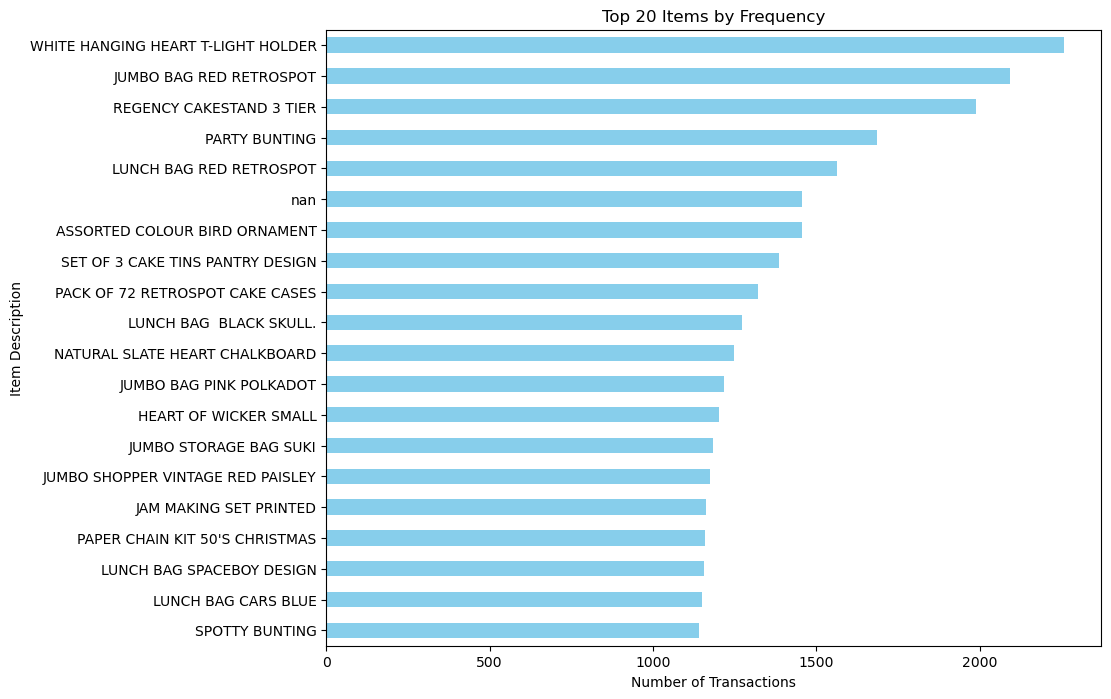

In [6]:
data_freq = data_freq = data[['Description', 'InvoiceNo']]

# Drop duplicates to count each item once per transaction
data_unique = data_freq.drop_duplicates()

# Count the occurrences of each item
item_frequency = data_unique['Description'].value_counts().sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(10, 8))
item_frequency.head(20).plot(kind='barh', color='skyblue')  # Displaying top 20 items for better visibility
plt.gca().invert_yaxis()  # Invert y-axis to display the highest frequencies on top

# Adding titles and labels
plt.title('Top 20 Items by Frequency')
plt.xlabel('Number of Transactions')
plt.ylabel('Item Description')

# Show the plot
plt.show()

In [7]:
# Top 10 most frequent items
item_frequency.head(10)

Description
WHITE HANGING HEART T-LIGHT HOLDER    2260
JUMBO BAG RED RETROSPOT               2092
REGENCY CAKESTAND 3 TIER              1989
PARTY BUNTING                         1686
LUNCH BAG RED RETROSPOT               1564
nan                                   1455
ASSORTED COLOUR BIRD ORNAMENT         1455
SET OF 3 CAKE TINS PANTRY DESIGN      1385
PACK OF 72 RETROSPOT CAKE CASES       1320
LUNCH BAG  BLACK SKULL.               1273
Name: count, dtype: int64

Let's analyze the number of items per transaction

In [8]:
data_purchases = data[['InvoiceNo', 'Description']]

# Drop duplicates to ensure each item in each transaction is counted once
data_unique_purch = data.drop_duplicates()

# Count the number of unique items in each transaction
transaction_item_counts = data_unique_purch.groupby('InvoiceNo').size()

# Calculate how many transactions have each count of items
frequency_of_item_counts = transaction_item_counts.value_counts().sort_index()

In [9]:
frequency_of_item_counts.describe(percentiles=[.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.90,.95,.99]).T

count    370.000
mean      59.632
std      233.317
min        1.000
1%         1.000
5%         1.000
10%        1.000
20%        1.000
30%        1.000
40%        2.000
50%        3.000
60%        4.000
70%        6.000
80%       28.200
90%      127.600
95%      440.650
99%      671.130
max     3712.000
Name: count, dtype: float64

In [10]:
frequency_of_item_counts.head(10)

1     3712
2      840
3      695
4      664
5      687
6      615
7      603
8      606
9      600
10     551
Name: count, dtype: int64

In [11]:
frequency_of_item_counts.tail(10)

652     1
662     1
675     1
676     1
687     1
705     1
721     1
731     1
749     1
1114    1
Name: count, dtype: int64

The data is highly skewed with a few transactions containing a very large number of items. The mean is not as representative of a "typical" transaction due to the influence of extreme outliers.

Let's handle outliers. We manually remove transactions with more than 20 items. We will focus in this notebook on finding association rules for relatively small transactions.

In [12]:
filtered_transactions = transaction_item_counts[transaction_item_counts <= 20]

In [13]:
filtered_transactions.describe(percentiles=[.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.90,.95,.99]).T

count   14553.000
mean        7.809
std         6.204
min         1.000
1%          1.000
5%          1.000
10%         1.000
20%         1.000
30%         2.000
40%         4.000
50%         7.000
60%         9.000
70%        12.000
80%        15.000
90%        17.000
95%        19.000
99%        20.000
max        20.000
dtype: float64

In [14]:
filtered_transactions.head(10)

InvoiceNo
536365     7
536366     2
536367    12
536368     4
536369     1
536370    20
536371     1
536372     2
536373    16
536374     1
dtype: int64

In [15]:
filtered_transactions.tail(10)

InvoiceNo
581574     13
581581      3
581582      2
581583      2
581584      2
581586      4
581587     15
A563185     1
A563186     1
A563187     1
dtype: int64

We will probably end up generating rules of length 2 to 3 due to the nature of the item distribution in the dataset.

### PREPARE DATA FOR RULE MINING
We should have one row for each purhcase

As we have seen, we'll use only transactions with no more than 20 items. Moreover, we have to remove missing values encoded as 'nan' and several expressions that appears as item descriptions. We prepare our data accordingly.

In [16]:
# Check if 'nan' is present in any column as a string
is_nan_string_present = (data == 'nan').any().any()
print("Is 'nan' string present in the data?", is_nan_string_present)

Is 'nan' string present in the data? True


In [17]:
# Replace 'nan' strings with actual NaN values
data.replace('nan', pd.NA, inplace=True)

# Drop rows with NaN in critical columns (now including 'nan' strings converted to NaN)
data.dropna(axis=0, subset=['InvoiceNo', 'Description'], inplace=True)

# Define the list of expressions to remove
unwanted_descriptions = [
    "add stock to allocate online orders", "adjust", "adjustment", "alan hodge cant mamage this section", 
    "alan hodge cant manage this section", "allocate stock for dotcom orders ta", 
    "amazon", "amazon adjust", "amazon sales", "barcode problem", "broken",
    "came coded as 20713", "can't find", "check", "check?", "code mix up? 84930",
    "counted", "cracked", "crushed", "crushed boxes", "crushed ctn",
    "damaged", "damaged stock", "damages", "damages wax", "damages/credits from ASOS.",
    "damages/display", "damages/dotcom?", "damages/showroom etc", "damages?", 
    "did a credit and did not tick ret", "did  a credit  and did not tick ret", "dotcom", "dotcom adjust", "dotcom sales", 
    "dotcom sold sets", "dotcomstock", "ebay", "faulty", "for online retail orders", 
    "found", "found box", "found some more on shelf", "had been put aside", 
    "historic computer difference?....se", "incorrect stock entry.", "incorrect stock entry.", 
    "incorrectly credited C550456 see 47", "incorrectly made-thrown away.", 
    "incorrectly put back into stock", "label mix up", "lost", "lost in space", "lost??", 
    "mailout", "michel oops", "missing", "missing?", "mix up with c", "mixed up", 
    "mouldy", "mouldy, thrown away.", "mouldy, unsaleable.", 
    "mystery! Only ever imported 1800", "on cargo order", "printing smudges/thrown away", 
    "rcvd be air temp fix for dotcom sit", "re dotcom quick fix.", "re-adjustment", 
    "returned", "reverse 21/5/10 adjustment", "reverse previous adjustment", 
    "rusty throw away", "rusty thrown away", "samples", "samples/damages", 
    "showroom", "smashed", "sold in set?", "sold as 1", "sold as 22467", "sold as set by dotcom", 
    "sold as set on dotcom", "sold as set on dotcom and amazon", 
    "sold as set/6 by dotcom", "sold in set?", "sold with wrong barcode", 
    "stock check", "stock credited wrongly", "stock creditted wrongly", "taig adjust", "taig adjust no stock", 
    "temp adjustment", "test", "throw away", "thrown away", "thrown away-can't sell", 
    "thrown away-can't sell.", "to push order through as stock was", "to push order througha s stock was", "water damage", 
    "water damaged", "website fixed", "wet", "wet boxes", "wet damaged", "wet pallet", 
    "wet rusty", "wet/rusty", "wet?", "wrong barcode", "wrong barcode (22467)", 
    "wrong code", "wrong code?", "wrongly coded 20713", "wrongly coded 23343", 
    "wrongly coded-23343", "wrongly marked", "wrongly marked 23343", 
    "wrongly marked carton 22804", "wrongly marked. 23343 in box", 
    "wrongly sold (22719) barcode", "wrongly sold as sets", "wrongly sold sets"
]

# Join the list into a single regular expression
pattern = r'\b(?:' + '|'.join(map(re.escape, unwanted_descriptions)) + r')\b'

# Filter the DataFrame: Keep rows that do NOT match the pattern
data = data[~data['Description'].str.contains(pattern, case=False, na=False)]

data['InvoiceNo'] = data['InvoiceNo'].astype('str')  # Convert InvoiceNo to string

# Filter transactions by size: only include those with 20 or fewer items
transactions = data.groupby('InvoiceNo')['Description'].apply(list)
transactions = transactions[transactions.map(len) <= 20]

# Step 4: Reset index and clean up
transactions = transactions.reset_index()
transactions.rename(columns={'Description': 'Items'}, inplace=True)

print("Filtered data shape:", transactions.shape)
print("\nSample filtered transactions:")
transactions.head()


Filtered data shape: (12509, 2)

Sample filtered transactions:


,InvoiceNo,Items
0,536365,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
1,536366,"[HAND WARMER UNION JACK, HAND WARMER RED POLKA..."
2,536367,"[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO..."
3,536368,"[JAM MAKING SET WITH JARS, RED COAT RACK PARIS..."
4,536369,[BATH BUILDING BLOCK WORD]


In [18]:
# Check if 'nan' is still present in any column as a string
is_nan_string_present = (data == 'nan').any().any()
print("Is 'nan' string present in the data?", is_nan_string_present)

Is 'nan' string present in the data? False


In [19]:
# Step 2: Convert transactions to a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions['Items']).transform(transactions['Items'])
df = pd.DataFrame(te_ary, columns=te.columns_)

print("One-hot encoded DataFrame shape:", df.shape)
print("\nSample of one-hot encoded data:")
df.head()

One-hot encoded DataFrame shape: (12509, 3529)

Sample of one-hot encoded data:


10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
0                   False                       False   
1                   False                       False   
2                   False                       False   
3                   False                       False   
4                   False                       False   

   12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
0                      False                      False   
1                      False                      False   
2                      False                      False   
3                      False                      False   
4                      False                      False   

   12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
0                         False                             False   
1                         False                             False   
2                         False                             False   
3                         False                             False   
4                         False                             False   

   12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
0                            False                          False   
1                            False                          False   
2                            False                          False   
3                            False                          False   
4                            False                          False   

   12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
0                                False                        False   
1                                False                        False   
2                                False                        False   
3                                False                        False   
4                                False                        False   

   12 PENCILS TALL TUBE POSY  12 PENCILS TALL TUBE RED RETROSPOT  \
0                      False                               False   
1                      False                               False   
2                      False                               False   
3                      False                               False   
4                      False                               False   

   12 PENCILS TALL TUBE SKULLS  12 PENCILS TALL TUBE WOODLAND  \
0                        False                          False   
1                        False                          False   
2                        False                          False   
3                        False                          False   
4                        False                          False   

   12 PINK HEN+CHICKS IN BASKET  12 PINK ROSE PEG PLACE SETTINGS  \
0                         False                            False   
1                         False                            False   
2                         False                            False   
3                         False                            False   
4                         False                            False   

   12 RED ROSE PEG PLACE SETTINGS  15 PINK FLUFFY CHICKS IN BOX  \
0                           False                         False   
1                           False                         False   
2                           False                         False   
3                           False                         False   
4                           False                         False   

   15CM CHRISTMAS GLASS BALL 20 LIGHTS  16 PIECE CUTLERY SET PANTRY DESIGN  \
0                                False                               False   
1                                False                               False   
2                                False                               False   
3                                False                               False   
4                                False        

### ASSOCIATION RULES

In [20]:
# Step 3: Generate frequent itemsets
min_support = 0.01  
frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
frequent_itemsets['itemset_length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print("Number of frequent itemsets:", len(frequent_itemsets))
print("\nTop 10 frequent itemsets by support:")
frequent_itemsets.nlargest(10, 'support')

Number of frequent itemsets: 197

Top 10 frequent itemsets by support:


,support,itemsets,itemset_length
172,0.065,(WHITE HANGING HEART T-LIGHT HOLDER),1
137,0.062,(REGENCY CAKESTAND 3 TIER),1
124,0.058,(POSTAGE),1
78,0.052,(JUMBO BAG RED RETROSPOT),1
8,0.047,(ASSORTED COLOUR BIRD ORNAMENT),1
116,0.047,(PARTY BUNTING),1
150,0.032,(SET OF 3 CAKE TINS PANTRY DESIGN),1
106,0.032,(NATURAL SLATE HEART CHALKBOARD),1
168,0.032,(VICTORIAN GLASS HANGING T-LIGHT),1
125,0.031,(RABBIT NIGHT LIGHT),1


In [21]:
# Step 4: Generate association rules
min_confidence = 0.5  # 50% confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.023,0.025,0.014,0.628,25.004,0.014,2.618,0.982
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.025,0.023,0.014,0.564,25.004,0.014,2.240,0.985
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.018,0.022,0.014,0.756,34.620,0.013,4.002,0.989
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.022,0.018,0.014,0.623,34.620,0.013,2.603,0.993
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.022,0.024,0.016,0.718,29.349,0.015,3.459,0.987


In [22]:
# Step 5: Function to find rules for specific items
def find_rules_for_item(rules, item, as_antecedent=True, as_consequent=True):
    mask = pd.Series(False, index=rules.index)
    if as_antecedent:
        mask |= rules['antecedents'].apply(lambda x: item in x)
    if as_consequent:
        mask |= rules['consequents'].apply(lambda x: item in x)
    return rules[mask]

# Example usage
item_of_interest = 'WHITE HANGING HEART T-LIGHT HOLDER'
item_rules = find_rules_for_item(rules, item_of_interest)
print(f"Rules involving '{item_of_interest}':")
item_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

Rules involving 'WHITE HANGING HEART T-LIGHT HOLDER':


,antecedents,consequents,support,confidence,lift
12,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.011,0.637,9.780


In [23]:
# search for rules with a specific "antecedent"
rules[rules["antecedents"].apply(lambda x: 'JUMBO BAG STRAWBERRY' in x)].sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
8,(JUMBO BAG STRAWBERRY),(JUMBO BAG RED RETROSPOT),0.019,0.052,0.012,0.645,12.476,0.011,2.673,0.937


### REFINING

In [24]:
# Step 6: Advanced Pruning Techniques
def is_redundant(rule1, rule2):
    """Check if rule1 is redundant with respect to rule2"""
    return (rule1['antecedents'].issubset(rule2['antecedents']) and
            rule1['consequents'] == rule2['consequents'] and
            rule1['confidence'] <= rule2['confidence'])

def prune_redundant_rules(rules):
    pruned_rules = rules.copy()
    to_remove = set()
    for i, rule1 in pruned_rules.iterrows():
        for j, rule2 in pruned_rules.iterrows():
            if i != j and is_redundant(rule1, rule2):
                to_remove.add(i)
                break
    return pruned_rules.drop(to_remove)

def prune_rules(rules, min_lift=1.5, max_rules=100, min_confidence=0.5):
    pruned = rules[(rules['lift'] >= min_lift) & (rules['confidence'] >= min_confidence)]
    pruned = prune_redundant_rules(pruned)
    return pruned.nlargest(max_rules, 'lift')

pruned_rules = prune_rules(rules)
print(f"Number of rules after advanced pruning: {len(pruned_rules)}")
print("\nTop 10 pruned rules by lift:")
pruned_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

Number of rules after advanced pruning: 12

Top 10 pruned rules by lift:


,antecedents,consequents,support,confidence,lift
15,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.011,0.861,39.440
16,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.011,0.694,38.577
17,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.011,0.604,38.577
14,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.011,0.800,32.703
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.014,0.628,25.004
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.014,0.564,25.004
13,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE),0.012,0.500,20.111
8,(JUMBO BAG STRAWBERRY),(JUMBO BAG RED RETROSPOT),0.012,0.645,12.476
7,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.016,0.574,11.089
9,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.011,0.564,10.906


### VISUALIZATION

In [25]:
# Step 7: Visualizations
def create_scatter_plot(rules):
    # Convert frozenset to string for plotly to be able to serialize
    rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(x))
    rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(x))
    
    fig = px.scatter(rules, x='support', y='confidence', size='lift', color='lift',
                     hover_data=['antecedents', 'consequents'],
                     labels={'support': 'Support', 'confidence': 'Confidence', 'lift': 'Lift'},
                     title='Association Rules: Support vs Confidence')
    return fig

def create_network_graph(rules, max_rules=20):
    G = nx.Graph()
    for _, rule in rules.nlargest(max_rules, 'lift').iterrows():
        antecedents = frozenset(rule['antecedents'])
        consequents = frozenset(rule['consequents'])
        G.add_edge(str(antecedents), str(consequents), weight=rule['lift'])
    
    pos = nx.spring_layout(G)
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
                            marker=dict(showscale=True, colorscale='YlGnBu', size=10, colorbar=dict(thickness=15, title='Node Connections')))

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f'{adjacencies[0]}<br># of connections: {len(adjacencies[1])}')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(title='Association Rules Network', showlegend=False, hovermode='closest',
                                     margin=dict(b=20,l=5,r=5,t=40), xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                     yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
    return fig

# Display scatter plot
scatter_fig = create_scatter_plot(pruned_rules)
scatter_fig.show()

# Display network graph
network_fig = create_network_graph(pruned_rules)
network_fig.show()

### RECOMMENDATION SYSTEM

In [26]:
# Step 8: Recommendation System
def get_recommendations(item, rules, top_n=5):
    item_rules = rules[rules['antecedents'].apply(lambda x: item in x)]
    recommendations = item_rules.nlargest(top_n, 'lift')
    return recommendations['consequents'].tolist()

# Example usage of recommendation system
item_to_recommend = 'GREEN REGENCY TEACUP AND SAUCER'
recommendations = get_recommendations(item_to_recommend, pruned_rules)
print(f"Top 5 recommendations for '{item_to_recommend}':")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

Top 5 recommendations for 'GREEN REGENCY TEACUP AND SAUCER':
1. PINK REGENCY TEACUP AND SAUCER
2. ROSES REGENCY TEACUP AND SAUCER
